## Problem Statement

Our client's own a music-streaming service and are enlisting our company toa develop a recommendation system for their users. This recommendation system will work based upon measuring the cosine similarity between tracks latent features. 

## Business Objective

Our business objective is to create a recommendation system that will enhance our user's enjoyment of music by providing them with songs that they will enjoy, thus enhancing their enjoyment of our streaming service. 

To achieve this we will utilize a content-based recommendation system that will recommend songs based upon the previous song the user has played.

## Stakeholder Questions

User Behavior & Engagement 

Content Optimization 

Personalization & Recommendations 

## Data

## Data Understanding

## Data Source

We utilized the 
[Spotify Track Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset) dataset available via [Kaggle](www.Kaggle.com), which contains 125,000 songs spread across 125 musical genres. The dataset tracks such features as song popularity, a song's energy and loudness, among many others. 

In [1]:
# !curl -L -o spotify-tracks-genre-dataset\
#  https://www.kaggle.com/datasets/thedevastator/spotify-tracks-genre-dataset

In [2]:
# !unzip spotify-tracks-genre-dataset -d data

In [3]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [4]:
# Setting options for QoL 
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [5]:
# Loading in our dataset
main_df = pd.read_csv('data/data.csv')
#genre_df = pd.read_csv('data/data_w_genres.csv')

## Data Description

Our dataframe has 21 columns with 114000 rows, and has 3 null values.


And has the following columns:

* 'popularity' - How popular the track is.
* 'duration_ms' - How long the track is in milliseconds.
* 'explicit' - Whether the song is considered explicit or not, a boolean value.
* 'danceability' - The measure of how easy it is to dance to the song ranging from 0.0 to 1.0. 
* 'energy' - The measure of intensity of the song, ranging from 0.0 to 1.0. 
* 'key' - This represents the root note of the musical key the song is in, i.e. 'C', but does not reflect the major or minor aspect of the key. Given as a string object. 
* 'loudness' - The loudness in decibels.
* 'mode' - The mode reflects whether the song is major (0) or minor (1). 
* 'speechiness' - The level of spoken word on a track, ranging from 0.0 to 1.0. A higher value of speechiness, the more spoken words the track employs.
* 'acousticness' - The level of acoustic instrumentation versus electric, ranging from 0.0 to 1.0. A 1.0 reflects that the song is percieved to be 100% acoustic. 
* 'instrumentalness' - The level of singing / vocalization on a track ranging from 0.0 to 1.0. A higher value of instrumentalness, the less vocalizing a song will contain. Note that, 'ooh' and 'aah' sounds are considered instrumental sounds. 
* 'liveness' - Indicates to what degree the song was performed in front of an audience, ranging from 0.0 to 1.0. Higher values indicate that the song was most likely performed live in concert. 
* 'valence' - This measures the tracks positivity or negativity, in terms of musical sound (not reflecting upon lyrical themes), ranging from 0.0 to 1.0, with the closer to 1.0 a track is, the 'happier' it sounds.
* 'tempo' - the tracks tempo in beats per minute / BPMs. 
* 'time_signature' - a tracks time signature as experessed as a numerical value from 3 through 7, to be understood as being followed by '/4', such as '3/4', '4/4'...etc. 
* 'track_genre' - the genre most commonly associated with the the track

From our descriptive statistics of our 'popularity' feature we see that the mean average popularity is
33.238535, with a standard deviation of 22.305078. 25% of tracks have a popularity of 17.000000 or less, 50% of 35.000000 or less, and 75% with 50.000000 or less. 100.00 is the maximum popularity.

In [6]:
# Begining our EDA with .info
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [7]:
main_df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [8]:
print(main_df.isna())

        valence   year  acousticness  artists  danceability  duration_ms  \
0         False  False         False    False         False        False   
1         False  False         False    False         False        False   
2         False  False         False    False         False        False   
3         False  False         False    False         False        False   
4         False  False         False    False         False        False   
...         ...    ...           ...      ...           ...          ...   
170648    False  False         False    False         False        False   
170649    False  False         False    False         False        False   
170650    False  False         False    False         False        False   
170651    False  False         False    False         False        False   
170652    False  False         False    False         False        False   

        energy  explicit     id  instrumentalness    key  liveness  loudness  \
0      

In [9]:
main_df.describe()

valence           year   acousticness   danceability  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        0.528587    1976.787241       0.502115       0.537396   
std         0.263171      25.917853       0.376032       0.176138   
min         0.000000    1921.000000       0.000000       0.000000   
25%         0.317000    1956.000000       0.102000       0.415000   
50%         0.540000    1977.000000       0.516000       0.548000   
75%         0.747000    1999.000000       0.893000       0.668000   
max         1.000000    2020.000000       0.996000       0.988000   

        duration_ms         energy       explicit  instrumentalness  \
count  1.706530e+05  170653.000000  170653.000000     170653.000000   
mean   2.309483e+05       0.482389       0.084575          0.167010   
std    1.261184e+05       0.267646       0.278249          0.313475   
min    5.108000e+03       0.000000       0.000000          0.000000   
25%    1.698270e+05       0.255000       0.000000          0.000000   
50%    2.074670e+05       0.471000       0.000000          0.000216   
75%    2.624000e+05       0.703000       0.000000          0.102000   
max    5.403500e+06       1.000000       1.000000          1.000000   

                 key       liveness       loudness           mode  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        5.199844       0.205839     -11.467990       0.706902   
std         3.515094       0.174805       5.697943       0.455184   
min         0.000000       0.000000     -60.000000       0.000000   
25%         2.000000       0.098800     -14.615000       0.000000   
50%         5.000000       0.136000     -10.580000       1.000000   
75%         8.000000       0.261000      -7.183000       1.000000   
max        11.000000       1.000000       3.855000       1.000000   

          popularity    speechiness          tempo  
count  170653.000000  170653.000000  170653.000000  
mean       31.431794       0.098393     116.861590  
std        21.826615       0.162740      30.708533  
min         0.000000       0.000000       0.000000  
25%        11.000000       0.034900      93.421000  
50%        33.000000       0.045000     114.729000  
75%        48.000000       0.075600     135.537000  
max       100.000000       0.970000     243.507000

In [10]:
main_df.shape

(170653, 19)

In [11]:
main_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

## Data Cleaning

In [12]:
columns_to_drop = ['id', 'id_artists']

In [13]:
# Dropping any rows where our 'popularity' values == 0.0

main_df = main_df[main_df['popularity'] > 0.0]

In [14]:
# Cleaning our artists feature so that it is more readable.
main_df['artists'] = main_df['artists'].str.strip("[]").str.replace("'", "")

In [15]:
# There are duplicate values in our dataset, some tracks are listed multiple times, so we will filter those out.
main_df = main_df.drop_duplicates(subset=['name', 'artists', 'release_date'], keep='first')

In [16]:
main_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  Sergei Rachmaninoff, James Levine, Berliner Ph...         0.279   
1                                         Dennis Day         0.819   
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...         0.328   
3                                       Frank Parker         0.275   
4                                         Phil Regan         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

## Data Preparation

In order to prepare our data, we will feature engineer a new column, 'meta_genre' that will combine the 114 unique track_genre values into like genres such as 'roots' (containing 'folk' and 'acoustic' music, etc.). These meta genres were created using domain knowledge, allmusic.com, and chatgpt with prompt to organize and group the track_genres listed. 

In [17]:
# main_df['track_genre'].value_counts()

In [18]:
# def genre_mapper(df, genre_column):
    
#     #my genre lists - to be revised
#     roots_list = ['acoustic', 'songwriter', 'folk', 'singer-songwriter']

#     country_list = ['country', 'gospel', 'honky-tonk', 'rockabilly','rock-n-roll']

#     house_list = ['progressive-house', 'deep-house', 'house', 'hicago-house', 'club']

#     techno_list = ['minimal-techno', 'techno', 'detroit-techno']

#     trance_list = ['trance', 'edm']

#     breakbeat_list = ['breakbeat', 'hardstyle', 'dubstep', 'drum-and-bass']

#     electro_list = ['idm', 'electronic', 'electro']

#     disco_list = ['disco', 'dance']
    
#     chinese_pop_list = ['mandopop','cantopop']

#     indian_and_middle_east_list = ['iranian','turkish', 'indian', 'malay']
    
#     european_list = ['british', 'german','french', 'swedish']

#     latin_list = ['latino', 'latin', 'tango', 'salsa','reggaeton', 'spanish']

#     brazil_list = ['brazil', 'samba', 'forro', 'pagode', 'sertanejo', 'mpb', 'afrobeat']
    
#     hiphop_rnb_list = ['r-n-b', 'hip-hop', 'funk', 'groove', 'hardcore']
    
#     punky_list = ['punk-rock', 'power-pop', 'punk', 'garage']
    
#     metal_list = ['black-metal', 'metal', 'heavy-metal', 'death-metal', 'industrial']
    
#     hardcore_list = ['grindcore', 'metalcore']
    
#     pop_music_list = ['pop', 'pop-film', 'synth-pop', 'happy']           
    
#     chill_vibes_list = ['new-age', 'chill','ambient', 'study', 'sleep', 'trip-hop']
    
#     guitar_rock_list = ['guitar','hard-rock','rock']

#     alt_rock_list = ['grunge', 'psych-rock', 'alternative','alt-rock']
    
#     kids_list = ['kids','children','disney']            
    
#     jazz_list = ['jazz', 'blues', 'soul']                 
    
#     japan_list = ['j-rock', 'j-pop', 'j-idol', 'j-dance', 'anime']
    
#     k_pop_list = ['k-pop']              
    
#     reggae_and_ska_list = ['ska', 'reggae', 'dancehall', 'dub']
    
#     non_music_special_interest_list = ['comedy', 'show-tunes', 'party', 'romance', 'world-music']
    
#     indie_list =   ['indie', 'indie-pop', 'emo', 'goth', 'sad']             
    
#     classical_and_opera_list = ['classical', 'opera', 'piano']


#     genre_mapping = {
#         'metal': metal_list,
#         'roots' : roots_list,
#         'breakbeat' : breakbeat_list,
#         'country' : country_list,
#         'house' : house_list,
#         'electro' : electro_list,
#         'disco' : disco_list,
#         'techno' : techno_list,
#         'trance' : trance_list,
#         'chinese_pop' : chinese_pop_list,
#         'indian_and_middle_east' : indian_and_middle_east_list,
#         'latin' : latin_list,
#         'european' : european_list,
#         'brazil' : brazil_list,
#         'brazil' : brazil_list,
#         'european' : european_list,
#         'hardcore' : hardcore_list,
#         'hiphop_rnb' : hiphop_rnb_list,
#         'punky' : punky_list, 
#         'pop_music' : pop_music_list, 
#         'chill_vibes' : chill_vibes_list,
#         'guitar_rock' : guitar_rock_list,
#         'hardcore' : hardcore_list,
#         'alt_rock' : alt_rock_list,
#         'kids' : kids_list,
#         'k_pop' : k_pop_list,
#         'jazz' : jazz_list,
#         'japan' : japan_list,
#         'reggae_and_ska' : reggae_and_ska_list, 
#         'non_music_special_interest' : non_music_special_interest_list,
#         'indie' : indie_list,
#         'classical' : classical_and_opera_list
#     }

#     #function to check genre
#     def get_meta_genre(genre):
#         for meta_genre, genre_set in genre_mapping.items():
#             if genre in genre_set:
#                 return meta_genre
#         return 'other' # for if no category is located.
    
#     df['meta_genre'] = df[genre_column].apply(get_meta_genre)

#     return df


In [19]:
# main_df = genre_mapper(main_df, 'track_genre')

In [20]:
# main_df['meta_genre'].value_counts()

Next, we will feature engineer a new column called root_note, that will reflect the root note and the major or minor mode that the key is in. For example, C Major, D sharp minor.
Please see data limitations for more on this. 

In [21]:
def map_tonality(key):
    '''Maps root note to string for easier data understanding'''

    # Mapping major keys to their relative minors
    key_dict = {
        0: 'C',  # C Major 
        1: 'C#',  # C# Major 
        2: 'D',  # D Major
        3: 'D#',  # D# Major 
        4: 'E',  # E Major 
        5: 'F',  # F Major
        6: 'F#',  # F# Major 
        7: 'G',  # G Major 
        8: 'G#',  # G# Major 
        9: 'A',  # A Major 
        10: 'A#',  # A# Major
        11: 'B'  # B Major 
    }

    return key_dict.get(key)  # Return the key name



In [22]:
main_df['root_note'] = main_df['key'].apply(map_tonality)

In [23]:
main_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  Sergei Rachmaninoff, James Levine, Berliner Ph...         0.279   
1                                         Dennis Day         0.819   
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...         0.328   
3                                       Frank Parker         0.275   
4                                         Phil Regan         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo root_note  
0       0.0366   80.954        A#  
1       0.4150   60.936         G  
2       0.0339  110.339        D#  
3       0.0354  100.109         F  
4       0.0380  101.665        D#

Next, we will create another new feature based upon the key and now also the mode, 'actual_key'. This will expand upon the root_note feature and tell us the root note and whether the song is in a major or minor mode. This is usually what is refered to as the key of the song.

In [24]:
def map_key(key, mode):
    '''Maps key and mode into a string representing the actual key'''

    # Mapping keys to names
    key_dict = {
        0: 'C',
        1: 'C#',
        2: 'D',
        3: 'D#',
        4: 'E',
        5: 'F',
        6: 'F#',
        7: 'G',
        8: 'G#',
        9: 'A',
        10: 'A#',
        11: 'B'
    }

    # Get the root note from the dictionary
    key_name = key_dict.get(key, 'Unknown')

    # Append 'Major' or 'Minor' based on mode
    if mode == 1:
        return f"{key_name} Major"
    elif mode == 0:
        return f"{key_name} Minor"
    return "Unknown"

In [25]:
# Utilizing our function 
main_df['actual_key'] = main_df.apply(lambda row: map_key(row['key'], row['mode']), axis=1)

In [26]:
main_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  Sergei Rachmaninoff, James Levine, Berliner Ph...         0.279   
1                                         Dennis Day         0.819   
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...         0.328   
3                                       Frank Parker         0.275   
4                                         Phil Regan         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo root_note actual_key  
0       0.0366   80.954        A#   A# Major  
1       0.4150   60.936         G    G Major  
2       0.0339  110.339        D#   D# Major  
3       0.0354  100.109         F    F Major  
4       0.0380  101.665        D#   D# Major

## Exploratory Data Analysis

In [27]:
len(main_df['artists'].unique())

28441

In [28]:
main_df['artists'].drop_duplicates(inplace=True)

In [29]:
len(main_df['artists'].unique())

28441

In [30]:
len(main_df['name'].unique())

109268

In [31]:
#let's create a function that will enable us to create histograms quickly in order to view the distribution of our dataset.

def histogram_plotter(df, bins=30, color='steelblue'):
    num_cols = df.columns 
    num_features = len(num_cols)
    
    # Determine subplot grid size
    cols_per_row = 4
    num_rows = (num_features + cols_per_row - 1) // cols_per_row  
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(16, 4 * num_rows))
    axes = axes.flatten()  

    sns.set_palette("pastel")
    
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], bins=bins, kde=True, color=color, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Count")

    plt.show();


In [32]:
numeric_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
                   'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
                   'valence', 'tempo']

In [33]:
# meta_grouped_df = main_df.groupby('meta_genre')[numeric_columns].mean()

In [34]:
# meta_grouped_mode_df = main_df.groupby('meta_genre')[numeric_columns].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

In [35]:
numeric_df = main_df[numeric_columns]

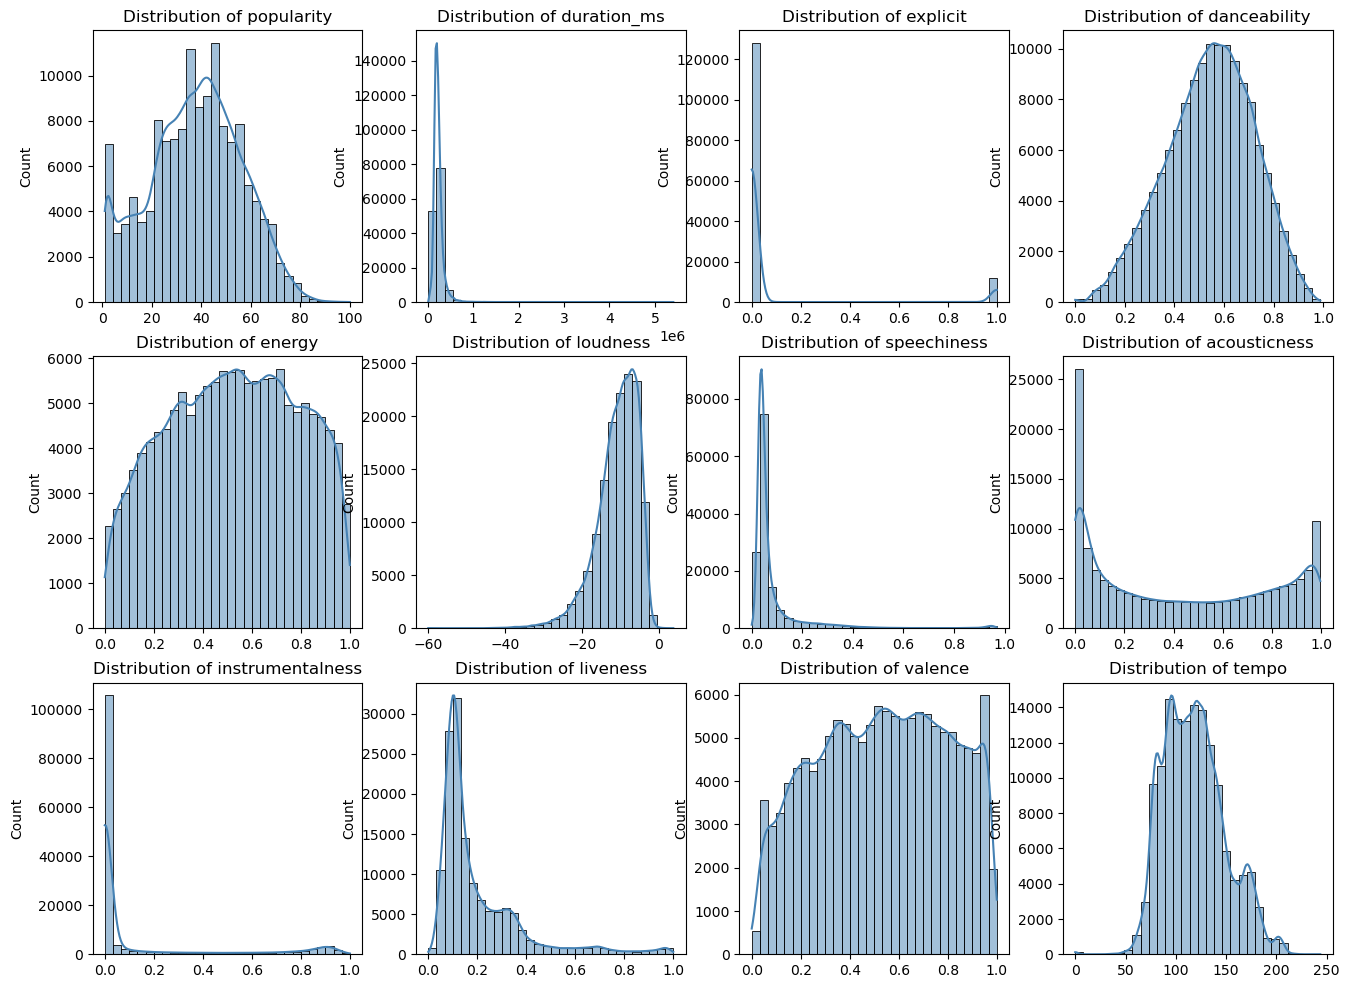

In [36]:
histogram_plotter(numeric_df)

From our plot of the numeric columns of 'main_df', we can make several observations that may bear further exploration:
Popularity appears more or less normally distributed, with a very high level of songs with 0 popularity that are outlierss. 
Our danceability feature also appears normaly distrbuted, though slightly skewed towards the higher end of danceability.
Energy skews towwards the highest end of the spectrum, with the majority of tracks being very energetic. Loudness, Speechiness, Acousticness, Instrumentalness, liveness, valence and tempo also all appeared more or less normally distributed within their ranges. 

In [37]:
# histogram_plotter(meta_grouped_df)

In [38]:
# histogram_plotter(meta_grouped_mode_df)

In [39]:
# Let's make a plot of the 10 most popular genres and their popularity.

In [40]:
# top_three_genres = (
#     main_df.groupby('meta_genre')
#     .mean(numeric_only=True)  # Ensures only numeric columns are used
#     .sort_values(by='popularity', ascending=False)
#     .head(3)  # Selects the top 10 genres
# ).reset_index()

In [41]:
# # Plotting the popularity by genre.

# plt.figure(figsize=(8, 4))
# sns.barplot(x=top_three_genres['meta_genre'], 
#             y=top_three_genres['popularity'].values, 
#             palette="viridis")

# # Customize the plot
# plt.xticks(rotation=90)  # Rotate genre labels for better readability
# plt.xlabel("Genre")
# plt.ylabel("Popularity Mean Average")
# plt.title("Average Mean Popularity Score of Movies by Genre")
# plt.show()

In [42]:
# top_three_genres.head()

K-Pop is the most popular genre, with a mean average popularity score of 56.896000. 
The next most popular genre is Indie, with a mean average popularity score of 41.794400, with the other most popular genres being close behind.

In [43]:
# # Plotting the average duration of the most popular songs.

# plt.figure(figsize=(8, 4))
# sns.barplot(x=top_three_genres['meta_genre'], 
#             y=top_three_genres['duration_ms'], 
#             palette="viridis")

# # Customize the plot
# plt.xticks(rotation=90)  # Rotate genre labels for better readability
# plt.xlabel("Genre")
# plt.ylabel("Duration")
# plt.title("Average Mean Duration of Songs by Genre");

In [44]:
# top_three_genres['duration_ms'].head()

In [45]:
avg_song_time = main_df['duration_ms'].mean()

In [46]:
avg_song_time

233740.31644128013

In [47]:
# top_genre_song_time = top_three_genres['duration_ms'].head(1)

In [48]:
# avg_song_time_value = avg_song_time / 1000 / 60 

In [49]:
# top_genre_song_time_value = top_three_genres['duration_ms'].head(1) / 1000 / 60 

In [50]:
# print(f'Average Song Time Value: {avg_song_time_value}')
# print(f'Average Song Time Value for Top Genre {top_three_genres['meta_genre'][0]} {top_genre_song_time_value}')

There is no substantial difference between the track duration's of the songs. 

In [51]:
# #Now we will create a new df that includes all of the songs that are in our top five genres.
# top_three_tracks = main_df[main_df['meta_genre'].isin(top_three_genres['meta_genre'])]

In [52]:
def scatter_plot(df, column):
    """
    Creates a scatter plot with:
    - X-axis: 'popularity'
    - Y-axis: the specified column
    - Hue: 'meta_genre'
    
    Args:
    df (pd.DataFrame): The dataframe containing the data.
    column (str): The column to plot on the y-axis.
    
    Returns:
    None (displays the plot)
    """
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df, x='popularity', y=column, hue='actual_key', alpha=0.7, palette='viridis')
    
    plt.title(f'Scatter Plot of {column} vs Popularity')
    plt.xlabel('Popularity')
    plt.ylabel(column)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True);

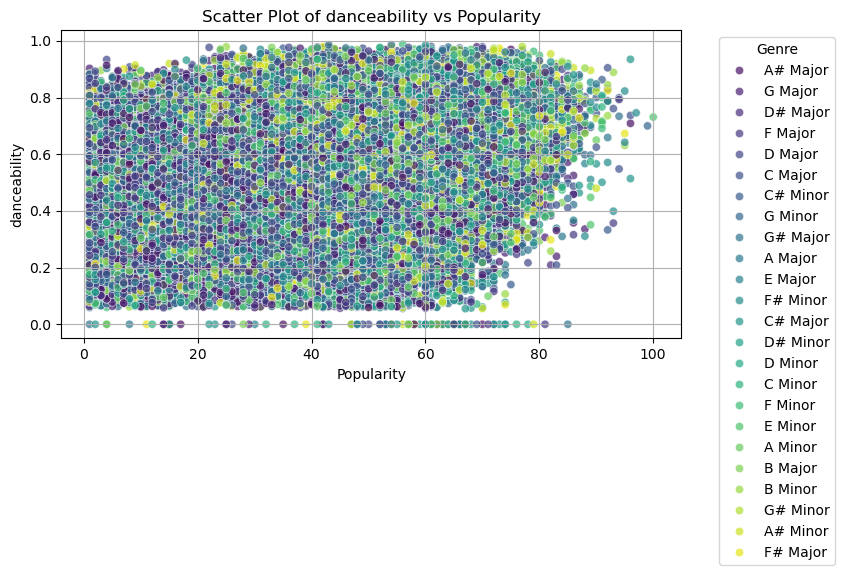

In [53]:
scatter_plot(main_df, 'danceability')

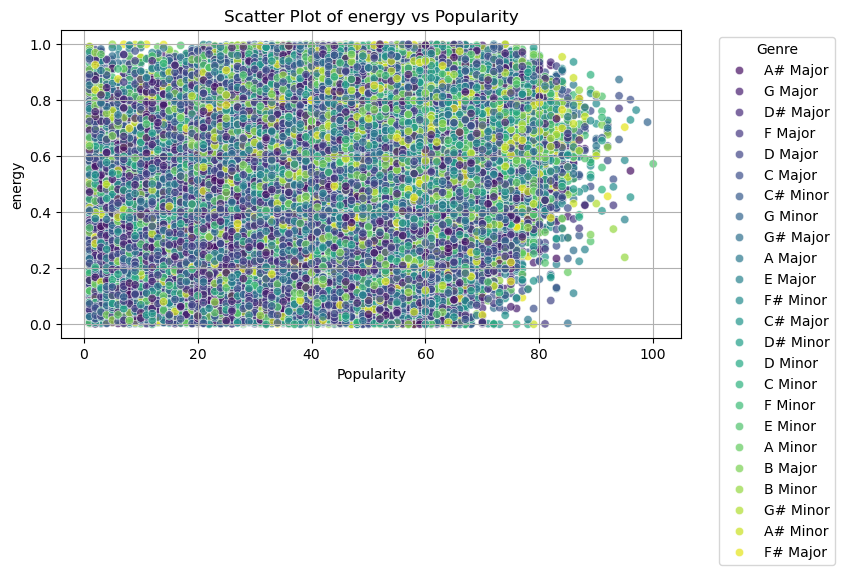

In [54]:
scatter_plot(main_df, 'energy')

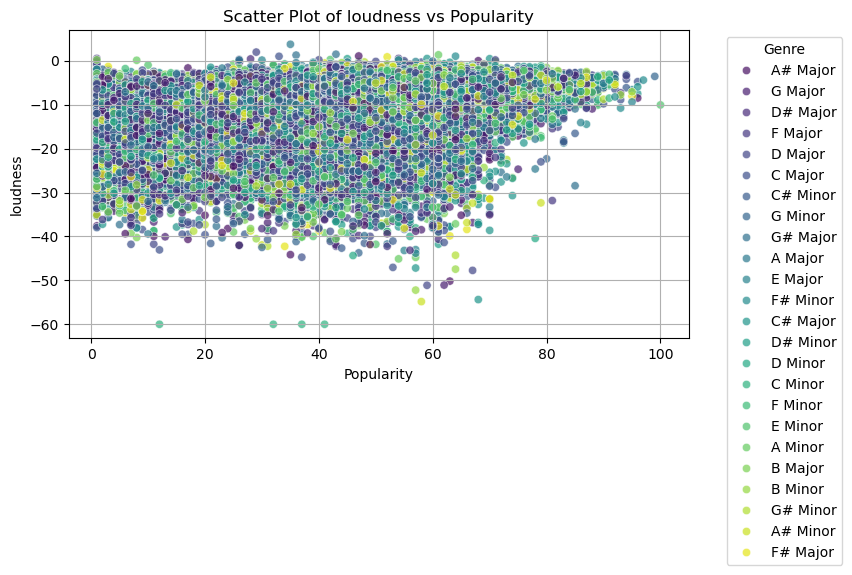

In [55]:
scatter_plot(main_df, 'loudness')

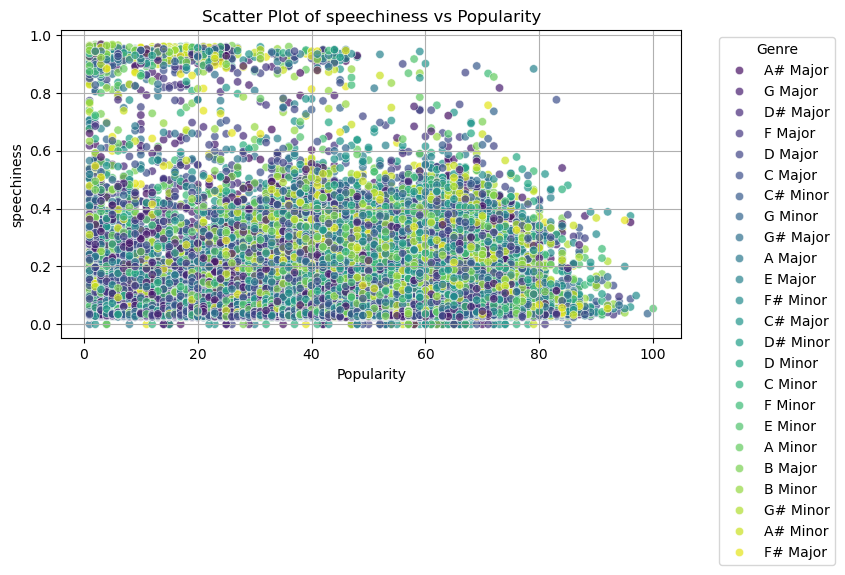

In [56]:
scatter_plot(main_df, 'speechiness')

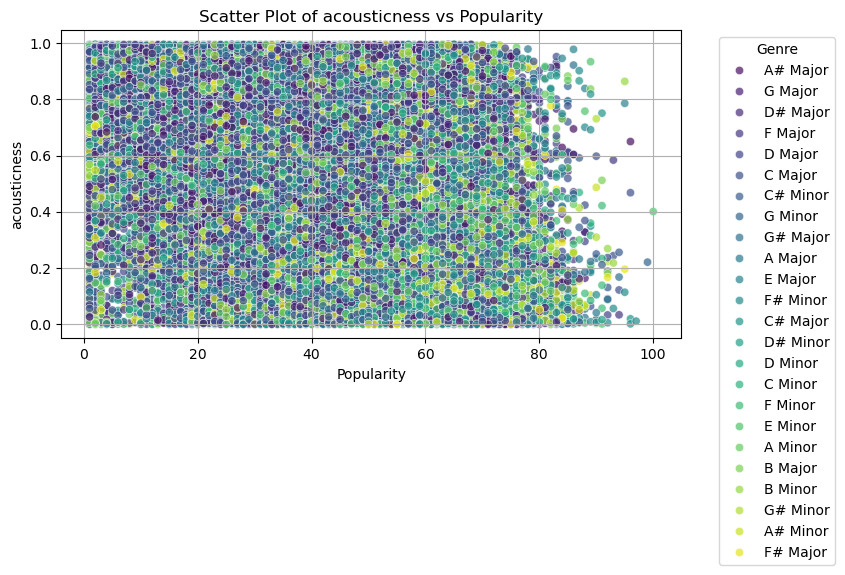

In [57]:
scatter_plot(main_df, 'acousticness')

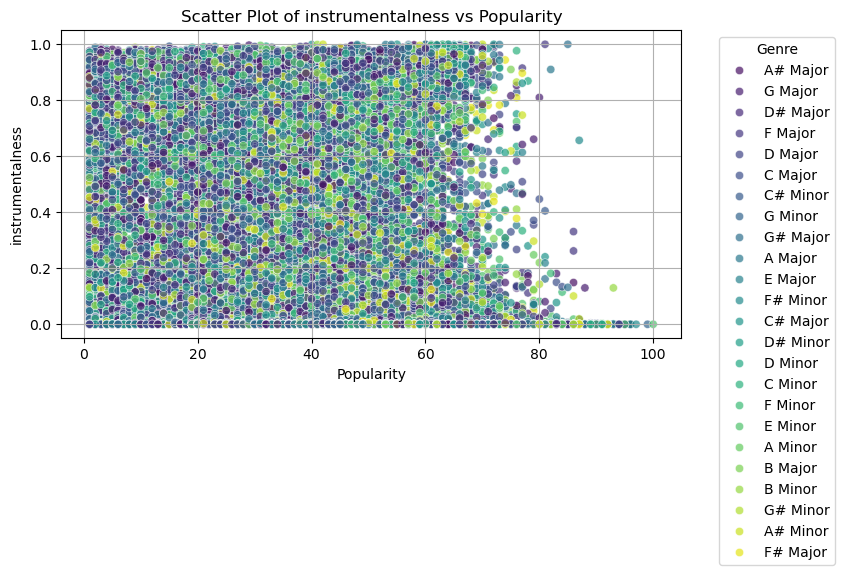

In [58]:
scatter_plot(main_df, 'instrumentalness')

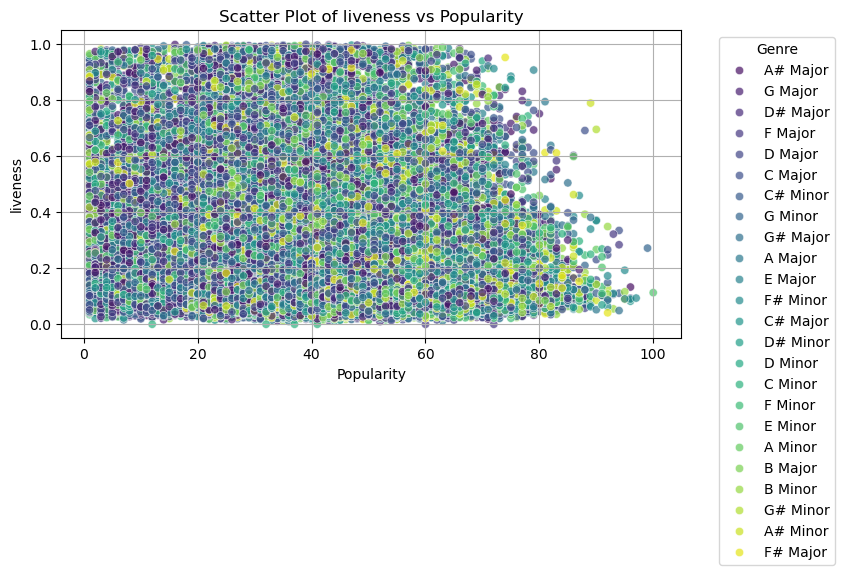

In [59]:
scatter_plot(main_df, 'liveness')

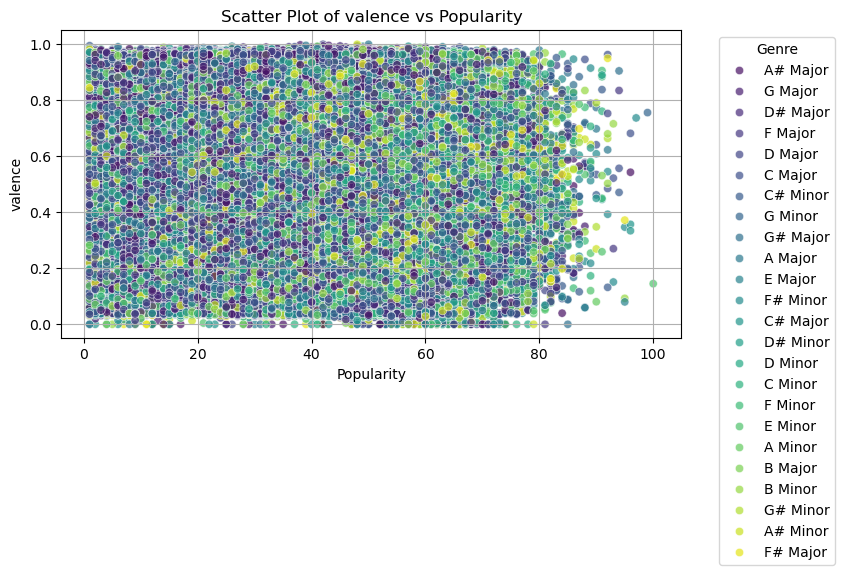

In [60]:
scatter_plot(main_df, 'valence')

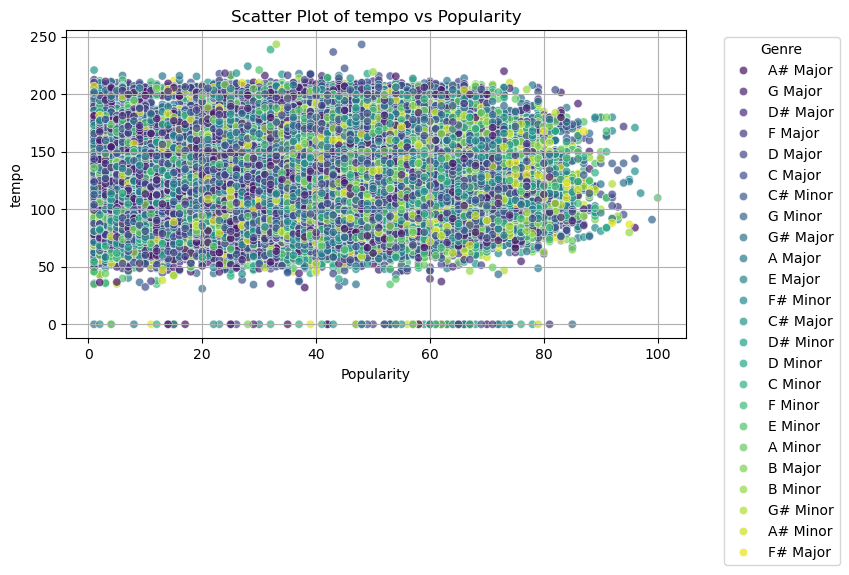

In [61]:
scatter_plot(main_df, 'tempo')

From these visualizations, we observe that indie music tends to be less danceable compared to pop and K-pop, which aligns with its generally lower energy levels. Additionally, indie music is the quietest among our most popular genres, with its less popular songs skewing toward higher loudness levels, while louder tracks tend to decrease in popularity.

Most songs exhibit low speechiness, with only a small number of indie and pop tracks approaching high speechiness values. Across all three top genres, acousticness varies significantly. However, indie music predominantly has values above 0.2, whereas pop frequently features values near or at 0.0, indicating a stronger preference for electronically produced sounds in the pop music industry.

In our instrumentalness scatter plot, we see that most tracks were not performed live, which aligns with the fact that the majority of songs fall below 0.4 in the liveness feature. Lastly, the distribution of valence and tempo values appears fairly even across the dataset.

In [62]:
main_df['popularity'].mean()

37.734163252442485

In [63]:
# Sort by popularity and get the top 5 most popular songs
top_five_most_popular = main_df.sort_values(by='popularity', ascending=False).head(5)


In [64]:
# Concatenate track name and artist for the x-axis labels
top_five_most_popular['track_artist'] = top_five_most_popular['name'] + ' - ' + top_five_most_popular['artists']

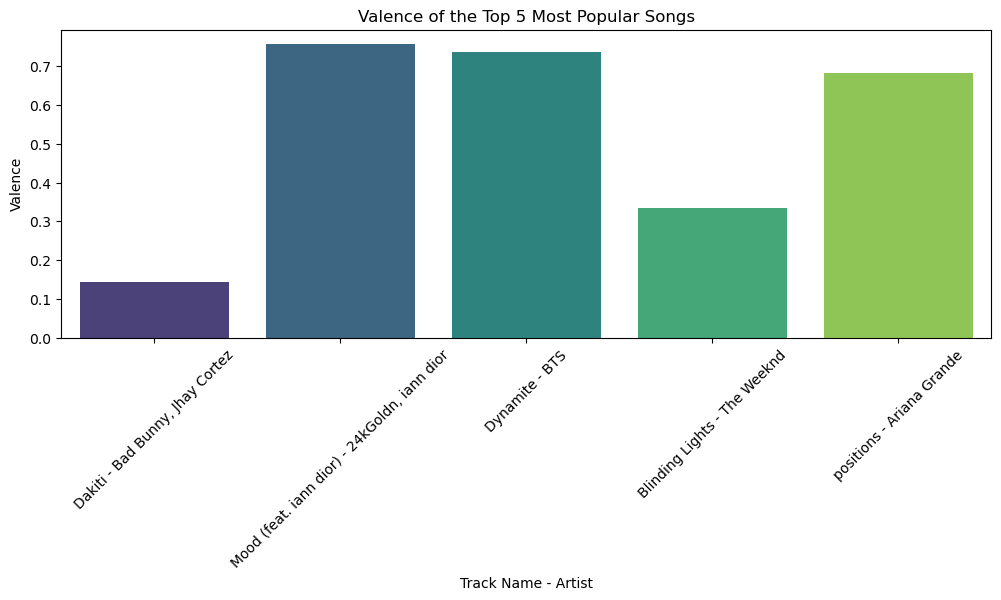

In [65]:

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(x=top_five_most_popular['track_artist'], y=top_five_most_popular['valence'], palette='viridis')

# Labels and title
plt.xlabel("Track Name - Artist")
plt.ylabel("Valence")
plt.title("Valence of the Top 5 Most Popular Songs")
plt.xticks(rotation=45)
plt.savefig('images/top_five_valence.png', bbox_inches='tight', pad_inches= 0.2);

## Modeling

## Baseline model

In [66]:
# Creating a OneHotEncoder to encode our categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [67]:
#categorical_features_list = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', ] 
# categorical_features_list = ['explicit', 'track_genre', 'root_note']
numerical_features_list =  ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence'] 
categorical_features_list = ['explicit', 'root_note']


In [68]:
encoder.fit(main_df[categorical_features_list])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [69]:
categorical_columns = encoder.get_feature_names_out(categorical_features_list)  # One-hot encoded columns for categorical features

In [70]:
# Pipeline for numerical features: VarianceThreshold -> MinMaxScaler -> Normalizer
num_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold(threshold=1e-4)),  # Remove low-variance features
    ('scaler', MinMaxScaler()),  # Scale features to [0,1] range
    ('normalizer', Normalizer())  # Normalize each sample to unit norm
])

# Creating the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', encoder, categorical_features_list),  # Apply encoder to categorical features
        ('numerical', num_pipeline, numerical_features_list)  # Apply numerical transformations
    ]
)

In [71]:
# Step 2: Fit and transform the data into a feature matrix
features_matrix = preprocessor.fit_transform(main_df)

In [72]:
# Step 3: Convert the features matrix into a DataFrame for readability
categorical_columns = encoder.get_feature_names_out(categorical_features_list)  # One-hot encoded columns for categorical features
all_columns = list(categorical_columns) + numerical_features_list  # Combine both categorical and numerical column names

In [73]:
# Create DataFrame from the feature matrix
features_df = pd.DataFrame(features_matrix, columns=all_columns)

In [74]:
# Display the feature matrix
print(features_df)

        explicit_0  explicit_1  root_note_A  root_note_A#  root_note_B  \
0              1.0         0.0          0.0           1.0          0.0   
1              1.0         0.0          0.0           0.0          0.0   
2              1.0         0.0          0.0           0.0          0.0   
3              1.0         0.0          0.0           0.0          0.0   
4              1.0         0.0          0.0           0.0          0.0   
...            ...         ...          ...           ...          ...   
139607         1.0         0.0          0.0           0.0          0.0   
139608         1.0         0.0          0.0           0.0          0.0   
139609         1.0         0.0          0.0           0.0          0.0   
139610         0.0         1.0          0.0           0.0          0.0   
139611         0.0         1.0          0.0           0.0          0.0   

        root_note_C  root_note_C#  root_note_D  root_note_D#  root_note_E  \
0               0.0           0.0 

In [75]:
# Initialize KNN model (using cosine similarity)
knn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')

In [76]:

# Fit the model on the feature matrix
knn.fit(features_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [77]:
# # Ask user for artist and track name
# artist_input = input("Enter the artist name: ").lower()
# track_input = input(f"Enter the track name by {artist_input.title()}: ").lower()

# # Find the index of the track in the DataFrame
# item_idx = main_df[(main_df['artists'].str.lower() == artist_input) & 
#                    (main_df['track_name'].str.lower() == track_input)].index

# # Ensure the track exists
# if len(item_idx) == 0:
#     print("Track not found. Please check the artist and track name and try again.")
# else:
#     item_idx = item_idx[0]  # Get the first matching index

#     # Get the original song details using .loc
#     original_track_name = main_df.loc[item_idx, 'track_name']
#     original_artist = main_df.loc[item_idx, 'artists']

#     # Print the selected song
#     print(f"\nOriginal Song: {original_track_name} by {original_artist}")

#     # Get recommendations (top 5 neighbors, including the item itself)
#     distances, indices = knn.kneighbors(features_df.iloc[item_idx].values.reshape(1, -1), n_neighbors=6)

#     # Set a threshold for similarity
#     threshold = 0.7

#     print(f"\nTop recommendations (cosine similarity > {threshold}):")
    
#     # Iterate over recommendations (excluding the original track)
#     for i, idx in enumerate(indices[0][1:]):  
#         similarity_score = 1 - distances[0][i+1]  # Convert distance to similarity
        
#         if similarity_score > threshold:
#             recommended_track_id = main_df.loc[idx, 'track_id']
#             recommended_artist = main_df.loc[idx, 'artists']
#             recommended_song = main_df.loc[idx, 'track_name']
            
#             print(f"Recommended Track: {recommended_song} by {recommended_artist} (Track ID: {recommended_track_id}, Similarity: {similarity_score:.4f})")


In [78]:
main_df[main_df['artists'] == 'Metallica']

valence  year  acousticness    artists  danceability  duration_ms  \
12250     0.435  1983      0.036400  Metallica         0.439       414720   
12279     0.329  1983      0.001710  Metallica         0.222       432547   
12332     0.188  1983      0.000608  Metallica         0.386       248547   
12360     0.287  1983      0.000043  Metallica         0.249       255867   
12384     0.349  1983      0.000116  Metallica         0.289       187840   
...         ...   ...           ...        ...           ...          ...   
166275    0.327  1998      0.000028  Metallica         0.458       192133   
166314    0.180  1999      0.000009  Metallica         0.263       446667   
166444    0.125  1999      0.000109  Metallica         0.239       444667   
168217    0.396  2008      0.000048  Metallica         0.256       597720   
169812    0.345  2016      0.000101  Metallica         0.566       419075   

        energy  explicit                      id  instrumentalness  key  \
12250    0.963         0  5DrNFzZZZVfXaEZCaceKnp           0.00896    9   
12279    0.938         0  4YPgTCGJWAlHQ5g6eWoM8r           0.08450    0   
12332    0.911         0  4k1IS2uF2dGcU3GzOOZqqb           0.44300    4   
12360    0.970         0  4OH1lqC4mx1ja8RkXMOmRp           0.22400    4   
12384    0.938         0  1QQgmN383kUqjioRoTSfF3           0.06150    1   
...        ...       ...                     ...               ...  ...   
166275   0.989         0  1mOrFr6ycCtOYIuUyy7uTC           0.03360    1   
166314   0.914         0  37DziDjAAxRySqsYGNYBlW           0.06070    3   
166444   0.976         0  2T9a3ToWrj8ijGUzCtlRNz           0.36200   11   
168217   0.955         0  0rd4qVsMPD8YtAZEpsalT6           0.83600    4   
169812   0.951         0  01LODLnhlfNphZ366BqKc0           0.10300    2   

        liveness  loudness  mode  \
12250     0.0784    -5.508     1   
12279     0.1080    -6.910     1   
12332     0.1350    -6.474     0   
12360     0.1380    -5.535     0   
12384     0.1060    -6.083     1   
...          ...       ...   ...   
166275    0.0445    -3.439     1   
166314    0.3790    -5.474     0   
166444    0.9540    -5.290     1   
168217    0.0877    -2.224     0   
169812    0.2660    -3.591     1   

                                                     name  popularity  \
12250                         Seek & Destroy (Remastered)          59   
12279                      The Four Horsemen (Remastered)          53   
12332                               Whiplash (Remastered)          49   
12360                         Hit The Lights (Remastered)          47   
12384                            Motorbreath (Remastered)          46   
...                                                   ...         ...   
166275                                  Too Late Too Late          32   
166314  The Thing That Should Not Be - Live with the SFSO          34   
166444                       Battery - Live with the SFSO          34   
168217                               Suicide & Redemption          39   
169812                                Now That We're Dead          51   

       release_date  speechiness    tempo root_note actual_key  
12250    1983-07-25       0.2770  140.805         A    A Major  
12279    1983-07-25       0.3750  203.098         C    C Major  
12332    1983-07-25       0.0956  158.045         E    E Minor  
12360    1983-07-25       0.2100  160.687         E    E Minor  
12384    1983-07-25       0.1630  173.882        C#   C# Major  
...             ...          ...      ...       ...        ...  
166275   1998-11-24       0.0751   98.027        C#   C# Major  
166314   1999-11-23       0.0593  112.990        D#   D# Minor  
166444   1999-11-23       0.3440   96.485         B    B Major  
168217   2008-09-12       0.0733  164.397         E    E Minor  
169812   2016-11-18       0.0464  128.304         D    D Major  

[194 rows x 21 columns]

In [79]:
# Ask user for artist and track name
artist_input = input("Enter the artist name: ").lower()
track_input = input(f"Enter the track name by {artist_input.title()}: ").lower()

# Find the index of the track in the DataFrame
item_idx = main_df[(main_df['artists'].str.lower() == artist_input) & 
                   (main_df['name'].str.lower() == track_input)].index

# Ensure the track exists
if len(item_idx) == 0:
    print("Track not found. Please check the artist and track name and try again.")
else:
    item_idx = item_idx[0]  # Get the first matching index

    # Get the original song details
    original_track_name = main_df.loc[item_idx, 'name']
    original_artist = main_df.loc[item_idx, 'artists']
    original_id = main_df.loc[item_idx, 'id']
    print(f"\nOriginal Song: {original_track_name} by {original_artist}, Track Id: {original_id}")

    # Get recommendations (top 5 neighbors, including the item itself)
    distances, indices = knn.kneighbors(features_df.iloc[item_idx].values.reshape(1, -1), n_neighbors=6)

    # Set a threshold for similarity
    threshold = 0.5

    # Iterate over recommendations (excluding the original track)
    for i, idx in enumerate(indices[0][1:]):  
        similarity_score = 1 - distances[0][i+1]  # Convert distance to similarity
        
        
        
        if similarity_score > threshold:
            try:
                recommended_song = main_df.loc[idx, 'name']
                recommended_artist = main_df.loc[idx, 'artists']
                recommended_track_id = main_df.loc[idx, 'id']

                print(f"\nRecommended Track: {recommended_song} by {recommended_artist} (Track ID: {recommended_track_id}, Similarity: {similarity_score:.4f})")
                break  # Stop after finding the first valid recommendation
            
            except KeyError:
                continue  # If the song ID is missing, try the next recommendation

    else:
        print("No valid recommendations found. Try another song.")


Enter the artist name:  Elvis Presley
Enter the track name by Elvis Presley:  Blue Christmas



Original Song: Blue Christmas by Elvis Presley, Track Id: 3QiAAp20rPC3dcAtKtMaqQ

Recommended Track: 10 Feet Down by NF, Ruelle (Track ID: 68biLwi894rMQPeIiSky2t, Similarity: 0.9993)


In [80]:
main_df['popularity'].max

<bound method Series.max of 0          4
1          5
2          5
3          3
4          2
          ..
170648    72
170649    68
170650    76
170651    70
170652    74
Name: popularity, Length: 139612, dtype: int64>

In [81]:
main_df[main_df['popularity'] == 74]

valence  year  acousticness  \
7006      0.580  1957        0.9000   
8011      0.958  1962        0.7150   
8210      0.937  1963        0.6410   
8410      0.328  1964        0.8370   
8614      0.562  1965        0.7290   
...         ...   ...           ...   
155487    0.485  2020        0.0433   
170524    0.499  2020        0.4910   
170627    0.629  2020        0.4100   
170636    0.394  2020        0.2010   
170652    0.642  2020        0.1320   

                                           artists  danceability  duration_ms  \
7006                                 Elvis Presley         0.465       129173   
8011                                   Roy Orbison         0.619       178933   
8210                                   The Beatles         0.482       155227   
8410                             Simon & Garfunkel         0.525       185413   
8614                                     Bob Dylan         0.483       369600   
...                                            ...           ...          ...   
155487                                         BTS         0.643       217404   
170524              Rasster, Erin Bloomer, Imanbek         0.746       174720   
170627  Rauw Alejandro, Myke Towers, Sky Rompiendo         0.809       184817   
170636                Myke Towers, Maluma, Farruko         0.775       250333   
170652                             KEVVO, J Balvin         0.856       189507   

        energy  explicit                      id  instrumentalness  key  \
7006     0.270         0  3QiAAp20rPC3dcAtKtMaqQ          0.001040    4   
8011     0.603         0  48i055G1OT5KxGGftwFxWy          0.000000    9   
8210     0.849         0  5ZBeML7Lf3FMEVviTyvi8l          0.000008    2   
8410     0.216         0  5y788ya4NvwhBznoDIcXwK          0.000000    6   
8614     0.721         0  3AhXZa8sUQht0UEdBJgpGc          0.000000    0   
...        ...       ...                     ...               ...  ...   
155487   0.667         0  3op7HNwLli54MBjFGzIlZO          0.000000    0   
170524   0.757         1  4x5ymi4akay9Fq5Xm1PW3E          0.001240    5   
170627   0.624         1  10u2iOS0r6plfb9GknD7g4          0.000000    8   
170636   0.633         1  70zg99pT51vB4wlMS7e4q7          0.000000   10   
170652   0.721         1  7HmnJHfs0BkFzX4x8j0hkl          0.004710    7   

        liveness  loudness  mode                                     name  \
7006      0.1450   -16.661     1                           Blue Christmas   
8011      0.0721    -9.481     1                         Oh, Pretty Woman   
8210      0.0414    -9.198     1        Twist And Shout - Remastered 2009   
8410      0.1070   -13.551     1  The Sound of Silence - Acoustic Version   
8614      0.1890    -6.836     1                     Like a Rolling Stone   
...          ...       ...   ...                                      ...   
155487    0.0904    -6.993     0                        Louder than bombs   
170524    0.0863    -6.078     0                  SAD - Imanbek xxx Remix   
170627    0.1080    -4.963     0                             Ponte Pa' Mi   
170636    0.2190    -3.332     0                         La Playa - Remix   
170652    0.1820    -4.928     1          Billetes Azules (with J Balvin)   

        popularity release_date  speechiness    tempo root_note actual_key  
7006            74   1957-10-15       0.0425   94.518         E    E Major  
8011            74         1962       0.0342  127.432         A    A Major  
8210            74   1963-03-22       0.0452  124.631         D    D Major  
8410            74   1964-10-19       0.0301  106.761        F#   F# Major  
8614            74   1965-08-30       0.0320   95.261         C    C Major  
...            ...          ...          ...      ...       ...        ...  
155487          74   2020-02-21       0.1520  145.999         C    C Minor  
170524          74   2020-05-22       0.0540  124.992         F    F Minor  
170627          74   2020-04-16       0.1550   

In [82]:

def calculate_cosine_similarity(item_1, item_2, features_df):
    """
    Calculates the cosine similarity between two tracks based on their feature vectors.

    Parameters:
    - item_1 (DataFrame): DataFrame row containing the first track.
    - item_2 (DataFrame): DataFrame row containing the second track.
    - features_df (DataFrame): DataFrame containing the feature vectors of all tracks.

    Returns:
    - float: Cosine similarity between the two tracks.
    """
    # Extract the index of each track
    idx_1 = item_1.index[0] if not item_1.empty else None
    idx_2 = item_2.index[0] if not item_2.empty else None

    # Ensure both tracks exist
    if idx_1 is None or idx_2 is None:
        return "One or both tracks not found."

    # Extract feature vectors
    vector1 = features_df.loc[idx_1].values.reshape(1, -1)
    vector2 = features_df.loc[idx_2].values.reshape(1, -1)

    # Compute cosine similarity
    similarity = cosine_similarity(vector1, vector2)[0][0]

    return similarity


In [83]:


item_1 = main_df[main_df['id'] == '3QiAAp20rPC3dcAtKtMaqQ']
item_2 = main_df[main_df['id'] == '68biLwi894rMQPeIiSky2t']

# Compute similarity
similarity_score = calculate_cosine_similarity(item_1, item_2, features_df)

print(f'Cosine Similarity: {similarity_score:.4f}')

Cosine Similarity: 0.9993


## Next Model

In [84]:
# Initialize KNN model (using cosine similarity)
knn = NearestNeighbors(n_neighbors=2, metric='cosine')
# Fit the model on the feature matrix
knn.fit(features_df)

NearestNeighbors(metric='cosine', n_neighbors=2)

In [85]:
# Ask user for artist and track name
artist_input = input("Enter the artist name: ").lower()
track_input = input(f"Enter the track name by {artist_input.title()}: ").lower()

# Find the index of the track in the DataFrame
item_idx = main_df[(main_df['artists'].str.lower() == artist_input) & 
                   (main_df['name'].str.lower() == track_input)].index

# Ensure the track exists
if len(item_idx) == 0:
    print("Track not found. Please check the artist and track name and try again.")
else:
    item_idx = item_idx[0]  # Get the first matching index

    # Get the original song details
    original_track_name = main_df.loc[item_idx, 'name']
    original_artist = main_df.loc[item_idx, 'artists']
    original_id = main_df.loc[item_idx, 'id']
    print(f"\nOriginal Song: {original_track_name} by {original_artist}, Track Id: {original_id}")

    # Get recommendations (top 5 neighbors, including the item itself)
    distances, indices = knn.kneighbors(features_df.iloc[item_idx].values.reshape(1, -1), n_neighbors=6)

    # Set a threshold for similarity
    threshold = 0.5

    # Iterate over recommendations (excluding the original track)
    for i, idx in enumerate(indices[0][1:]):  
        similarity_score = 1 - distances[0][i+1]  # Convert distance to similarity
        
        
        
        if similarity_score > threshold:
            try:
                recommended_song = main_df.loc[idx, 'name']
                recommended_artist = main_df.loc[idx, 'artists']
                recommended_track_id = main_df.loc[idx, 'id']

                print(f"\nRecommended Track: {recommended_song} by {recommended_artist} (Track ID: {recommended_track_id}, Similarity: {similarity_score:.4f})")
                break  # Stop after finding the first valid recommendation
            
            except KeyError:
                continue  # If the song ID is missing, try the next recommendation

    else:
        print("No valid recommendations found. Try another song.")


Enter the artist name:  Elvis Presley
Enter the track name by Elvis Presley:  Blue Christmas



Original Song: Blue Christmas by Elvis Presley, Track Id: 3QiAAp20rPC3dcAtKtMaqQ

Recommended Track: 10 Feet Down by NF, Ruelle (Track ID: 68biLwi894rMQPeIiSky2t, Similarity: 0.9993)


In [86]:

item_1 = main_df[main_df['id'] == '5BIMPccDwShpXq784RJlJp']
item_2 = main_df[main_df['id'] == '74Uyg48KzZmJIXA302c5nA']

# Compute similarity
similarity_score = calculate_cosine_similarity(item_1, item_2, features_df)

print(f'Cosine Similarity: {similarity_score:.4f}')

Cosine Similarity: 0.9998


In [87]:
# Creating a OneHotEncoder to encode our categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#categorical_features_list = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', ] 
# categorical_features_list = ['explicit', 'track_genre', 'root_note']
numerical_features_list =  ['danceability', 'acousticness', 'instrumentalness'] 
categorical_features_list = ['root_note']

encoder.fit(main_df[categorical_features_list])
categorical_columns = encoder.get_feature_names_out(categorical_features_list)  # One-hot encoded columns for categorical features

# Creating the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', encoder, categorical_features_list),  # Apply encoder to categorical features
        ('numerical', num_pipeline, numerical_features_list)  # Apply numerical transformations
    ]
)
# Step 2: Fit and transform the data into a feature matrix
features_matrix = preprocessor.fit_transform(main_df)

# Step 3: Convert the features matrix into a DataFrame for readability
categorical_columns = encoder.get_feature_names_out(categorical_features_list)  # One-hot encoded columns for categorical features
all_columns = list(categorical_columns) + numerical_features_list  # Combine both categorical and numerical column names

# Create DataFrame from the feature matrix
features_df = pd.DataFrame(features_matrix, columns=all_columns)

# Initialize KNN model (using cosine similarity)
knn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')
# Fit the model on the feature matrix
knn.fit(features_df)
# Ask user for artist and track name
artist_input = input("Enter the artist name: ").lower()
track_input = input(f"Enter the track name by {artist_input.title()}: ").lower()

# Find the index of the track in the DataFrame
item_idx = main_df[(main_df['artists'].str.lower() == artist_input) & 
                   (main_df['name'].str.lower() == track_input)].index

# Ensure the track exists
if len(item_idx) == 0:
    print("Track not found. Please check the artist and track name and try again.")
else:
    item_idx = item_idx[0]  # Get the first matching index

    # Get the original song details
    original_track_name = main_df.loc[item_idx, 'name']
    original_artist = main_df.loc[item_idx, 'artists']
    original_id = main_df.loc[item_idx, 'id']
    print(f"\nOriginal Song: {original_track_name} by {original_artist}, Track Id: {original_id}")

    # Get recommendations (top 5 neighbors, including the item itself)
    distances, indices = knn.kneighbors(features_df.iloc[item_idx].values.reshape(1, -1), n_neighbors=6)

    # Set a threshold for similarity
    threshold = 0.5

    # Iterate over recommendations (excluding the original track)
    for i, idx in enumerate(indices[0][1:]):  
        similarity_score = 1 - distances[0][i+1]  # Convert distance to similarity
        
        
        
        if similarity_score > threshold:
            try:
                recommended_song = main_df.loc[idx, 'name']
                recommended_artist = main_df.loc[idx, 'artists']
                recommended_track_id = main_df.loc[idx, 'id']

                print(f"\nRecommended Track: {recommended_song} by {recommended_artist} (Track ID: {recommended_track_id}, Similarity: {similarity_score:.4f})")
                break  # Stop after finding the first valid recommendation
            
            except KeyError:
                continue  # If the song ID is missing, try the next recommendation

    else:
        print("No valid recommendations found. Try another song.")

Enter the artist name:  Elvis Presley
Enter the track name by Elvis Presley:  Blue Christmas



Original Song: Blue Christmas by Elvis Presley, Track Id: 3QiAAp20rPC3dcAtKtMaqQ

Recommended Track: Give My Love to Rose by Johnny Cash (Track ID: 2pjglEk3fqfi8oGWpCSVOm, Similarity: 0.9997)


## Final Model

In [93]:
# Creating a OneHotEncoder to encode our categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#categorical_features_list = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', ] 
# categorical_features_list = ['explicit', 'track_genre', 'root_note']
numerical_features_list =  ['danceability', 'acousticness', 'instrumentalness', 'loudness'] 
categorical_features_list = ['root_note']

encoder.fit(main_df[categorical_features_list])
categorical_columns = encoder.get_feature_names_out(categorical_features_list)  # One-hot encoded columns for categorical features

# Creating the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', encoder, categorical_features_list),  # Apply encoder to categorical features
        ('numerical', num_pipeline, numerical_features_list)  # Apply numerical transformations
    ]
)
# Step 2: Fit and transform the data into a feature matrix
features_matrix = preprocessor.fit_transform(main_df)

# Step 3: Convert the features matrix into a DataFrame for readability
categorical_columns = encoder.get_feature_names_out(categorical_features_list)  # One-hot encoded columns for categorical features
all_columns = list(categorical_columns) + numerical_features_list  # Combine both categorical and numerical column names

# Create DataFrame from the feature matrix
features_df = pd.DataFrame(features_matrix, columns=all_columns)

# Initialize KNN model (using cosine similarity)
knn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')
# Fit the model on the feature matrix
knn.fit(features_df)
# Ask user for artist and track name
artist_input = input("Enter the artist name: ").lower()
track_input = input(f"Enter the track name by {artist_input.title()}: ").lower()

# Find the index of the track in the DataFrame
item_idx = main_df[(main_df['artists'].str.lower() == artist_input) & 
                   (main_df['name'].str.lower() == track_input)].index

# Ensure the track exists
if len(item_idx) == 0:
    print("Track not found. Please check the artist and track name and try again.")
else:
    item_idx = item_idx[0]  # Get the first matching index

    # Get the original song details
    original_track_name = main_df.loc[item_idx, 'name']
    original_artist = main_df.loc[item_idx, 'artists']
    original_id = main_df.loc[item_idx, 'id']
    print(f"\nOriginal Song: {original_track_name} by {original_artist}, Track Id: {original_id}")

    # Get recommendations (top 5 neighbors, including the item itself)
    distances, indices = knn.kneighbors(features_df.iloc[item_idx].values.reshape(1, -1), n_neighbors=6)

    # Set a threshold for similarity
    threshold = 0.5

    # Iterate over recommendations (excluding the original track)
    for i, idx in enumerate(indices[0][1:]):  
        similarity_score = 1 - distances[0][i+1]  # Convert distance to similarity
        
        
        
        if similarity_score > threshold:
            try:
                recommended_song = main_df.loc[idx, 'name']
                recommended_artist = main_df.loc[idx, 'artists']
                recommended_track_id = main_df.loc[idx, 'id']

                print(f"\nRecommended Track: {recommended_song} by {recommended_artist} (Track ID: {recommended_track_id}, Similarity: {similarity_score:.4f})")
                break  # Stop after finding the first valid recommendation
            
            except KeyError:
                continue  # If the song ID is missing, try the next recommendation

    else:
        print("No valid recommendations found. Try another song.")

Enter the artist name:  Elvis Presley
Enter the track name by Elvis Presley:  Blue Christmas



Original Song: Blue Christmas by Elvis Presley, Track Id: 3QiAAp20rPC3dcAtKtMaqQ

Recommended Track: Give My Love to Rose by Johnny Cash (Track ID: 2pjglEk3fqfi8oGWpCSVOm, Similarity: 0.9996)


This recommendation seems more accurate to what we want, removing some features made the recommendation system work slightly better, in my estimation using domain knowledge.

## Evaluation

In [94]:

def calculate_cosine_similarity(item_1, item_2, features_df):
    """
    Calculates the cosine similarity between two tracks based on their feature vectors.

    Parameters:
    - item_1 (DataFrame): DataFrame row containing the first track.
    - item_2 (DataFrame): DataFrame row containing the second track.
    - features_df (DataFrame): DataFrame containing the feature vectors of all tracks.

    Returns:
    - float: Cosine similarity between the two tracks.
    """
    # Extract the index of each track
    idx_1 = item_1.index[0] if not item_1.empty else None
    idx_2 = item_2.index[0] if not item_2.empty else None

    # Ensure both tracks exist
    if idx_1 is None or idx_2 is None:
        return "One or both tracks not found."

    # Extract feature vectors
    vector1 = features_df.loc[idx_1].values.reshape(1, -1)
    vector2 = features_df.loc[idx_2].values.reshape(1, -1)

    # Compute cosine similarity
    similarity = cosine_similarity(vector1, vector2)[0][0]

    return similarity

In [95]:
item_1 = main_df[main_df['id'] == '3QiAAp20rPC3dcAtKtMaqQ']
item_2 = main_df[main_df['id'] == '2pjglEk3fqfi8oGWpCSVOm']

# Compute similarity
similarity_score = calculate_cosine_similarity(item_1, item_2, features_df)

print(f'Cosine Similarity: {similarity_score:.4f}')

Cosine Similarity: 0.9996


In [96]:
# Define the track_ids of interest
track_ids = ['3QiAAp20rPC3dcAtKtMaqQ', '2pjglEk3fqfi8oGWpCSVOm']

# Select a random track_id from the dataset
random_track = random.choice(main_df['id'].values)

# Add the random track_id to the list
track_ids.append(random_track)

In [109]:
import random
random.seed(42)

# Define the track_ids of interest
track_ids = ['3QiAAp20rPC3dcAtKtMaqQ', '2pjglEk3fqfi8oGWpCSVOm']
# Select a random track_id from the dataset
random_track = random.choice(main_df['id'].values)

# Add the random track_id to the list
track_ids.append(random_track)


# Filter the data to get the rows corresponding to these track_ids
tracks_of_interest = main_df[main_df['id'].isin(track_ids)]

In [110]:
random_track

'3oXNIpoUMdk8qGkwCeXqGv'

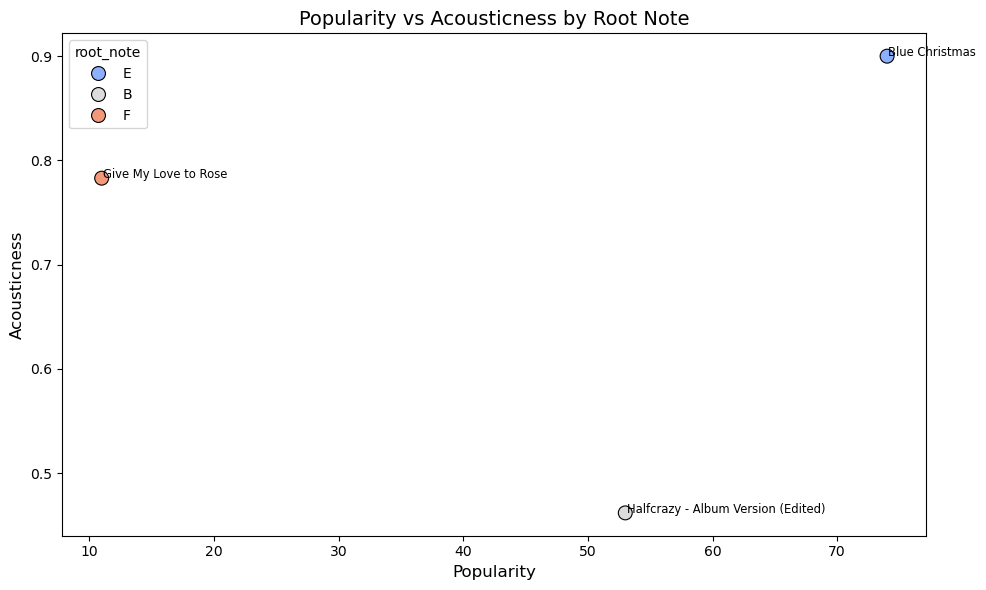

In [115]:

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='popularity', 
    y='acousticness', 
    hue='root_note', 
    data=tracks_of_interest, 
    palette='coolwarm',  # Color palette for root notes
    s=100,  # Size of points
    edgecolor='black',  # Edges for better visibility
    legend='full'  # Show the full legend
)

# Add text labels for each point
for line in range(0, tracks_of_interest.shape[0]):
    plt.text(
        x=tracks_of_interest['popularity'].iloc[line] + 0.1, 
        y=tracks_of_interest['acousticness'].iloc[line], 
        s=tracks_of_interest['name'].iloc[line], 
        horizontalalignment='left', 
        size='small', 
        color='black'
    )

# Labels and title
plt.xlabel("Popularity", fontsize=12)
plt.ylabel("Acousticness", fontsize=12)
plt.title("Popularity vs Acousticness by Root Note", fontsize=14)

# Show the plot
plt.tight_layout()
plt.savefig('images/pop_acoustic_root_note.png', bbox_inches='tight', pad_inches= 0.2);


In [112]:
random_track

'3oXNIpoUMdk8qGkwCeXqGv'

In [102]:
elvis_id = main_df[main_df['id'] == '3QiAAp20rPC3dcAtKtMaqQ']
cash_id = main_df[main_df['id'] == '2pjglEk3fqfi8oGWpCSVOm']

# Compute similarity
similarity_score = calculate_cosine_similarity(elvis_id, cash_id, features_df)

print(f'Cosine Similarity: {similarity_score:.4f}')

Cosine Similarity: 0.9996


In [113]:
half_crazy = main_df[main_df['id'] == '3oXNIpoUMdk8qGkwCeXqGv']


In [114]:

# Compute similarity
similarity_score = calculate_cosine_similarity(elvis_id, half_crazy, features_df)

print(f'Cosine Similarity: {similarity_score:.4f}')

Cosine Similarity: 0.4264


While we cannot measure our cosine similarity score against anything other than itself, this provides a working model to start with our recommendation system. 

For the future we will consider implementing features such as: filtering tracks by genres, recommending tracks that are only within the same genre as the original chosen song, creating playlists of that genre or of multilple genres. 

## Conclusion